# Tensor Robust Principal Component Analysis

**Published**: December 14, 2019

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the repository of [**tensor-learning**](https://github.com/xinychen/tensor-learning/blob/master/content/TRPCA.ipynb).

This post focuses on introducing Tensor Robust Principal Component Analysis (TRPCA) and implementing it. TRPCA is from

> Canyi Lu, Jiashi Feng, Yudong Chen, Wei Liu, Zhouchen Lin, Shuicheng Yan, 2016. Tensor Robust Principal Component Analysis: Exact Recovery of Corrupted Low-Rank Tensors via Convex Optimization. CVPR 2016. [[**PDF**](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Lu_Tensor_Robust_Principal_CVPR_2016_paper.pdf)] [[**Matlab code**](https://github.com/canyilu/Tensor-Robust-Principal-Component-Analysis-TRPCA)]

## Model Formulation

Suppose a third-order tensor $\boldsymbol{\mathcal{Y}}\in\mathbb{R}^{n_1\times n_2\times n_3}$ such that $\boldsymbol{\mathcal{Y}}=\boldsymbol{\mathcal{L}}_{0}+\boldsymbol{\mathcal{S}}_{0}$, where $\boldsymbol{\mathcal{L}}_0$ has low tubal rank and $\boldsymbol{\mathcal{S}}_0$ is sparse. Under certain suitable situations, it is possible to recover both the low-rank and the sparse components exactly by simply solving a convex optimization problem whose objective function is a weighted combination of the tensor nuclear norm and $\ell_1$-norm, i.e.,
\begin{equation}
\min _{\boldsymbol{\mathcal{L}}, \boldsymbol{\mathcal{E}}}\|\boldsymbol{\mathcal{L}}\|_{*}+\lambda\|\boldsymbol{\mathcal{E}}\|_{1}, \text { s.t. } \boldsymbol{\mathcal{Y}}=\boldsymbol{\mathcal{L}}+\boldsymbol{\mathcal{E}},
\end{equation}
where $\lambda=1 / \sqrt{\max \left(n_{1}, n_{2}\right) n_{3}}$.

In [1]:
import numpy as np

def svt(mat, tau):
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    vec = s - tau
    vec[vec < 0] = 0
    return np.matmul(np.matmul(u, np.diag(vec)), v)

In [2]:
def shrinkage(var, tau):
    var1 = var - tau
    var1[var1 < 0] = 0
    var2 = var + tau
    var2[var2 > 0] = 0
    return var1 + var2

In [11]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [12]:
def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

In [18]:
def trpca(dense_tensor, sparse_tensor, alpha, beta, rho, maxiter):
    
    dim1, dim2, dim3 = sparse_tensor.shape
    dim = np.array([dim1, dim2, dim3])
    pos_train = np.where(sparse_tensor != 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor[pos_train] = 1
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, len(dim))) # \boldsymbol{\mathcal{X}}
    E = np.zeros((dim1, dim2, dim3, len(dim))) # \boldsymbol{\mathcal{X}}
    Z = np.zeros((dim1, dim2, dim3, len(dim))) # \boldsymbol{\mathcal{Z}}
    T = np.zeros((dim1, dim2, dim3, len(dim))) # \boldsymbol{\mathcal{T}}
    for it in range(maxiter):
        for k in range(len(dim)):
            Z[:, :, :, k] = tensor_hat
            X[:, :, :, k] = mat2ten(svt(ten2mat(Z[:, :, :, k] - E[:, :, :, k] 
                                                + T[:, :, :, k] / rho, k), alpha / rho), dim, k)
        E = shrinkage(Z - X + T / rho, beta / rho)
        Z = X + E - T / rho
        for k in range(len(dim)):
            Z[:, :, :, k][pos_train] = sparse_tensor[pos_train]
        T = T + rho * (Z - X - E)
        tensor_hat = np.mean(Z, axis = 3)
        rmse = np.sqrt(np.sum((dense_tensor[pos_test] - tensor_hat[pos_test]) ** 2) / dense_tensor[pos_test].shape[0])
        if (it + 1) % 1 == 0:
            print('Iter: {}'.format(it + 1))
            print('RMSE: {:.6}'.format(rmse))
            print()
    tensor_hat = np.mean(X, axis = 3)
    if maxiter >= 100:
        final_mape = np.sum(np.abs(dense_tensor[pos_test] - tensor_hat[pos_test]) 
                            / dense_tensor[pos_test]) / dense_tensor[pos_test].shape[0]
        final_rmse = np.sqrt(np.sum((dense_tensor[pos_test] - tensor_hat[pos_test]) ** 2) / dense_tensor[pos_test].shape[0])
        print('Imputation MAPE: {:.6}'.format(final_mape))
        print('Imputation RMSE: {:.6}'.format(final_rmse))
        print()

    return tensor_hat

In [7]:
import imageio

name0 = ["lena"]
name = ["lena_mar"]
image = imageio.imread('../datasets/color-images/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('../datasets/color-images/{}.bmp'.format(name[0]))

In [19]:
import matplotlib.pyplot as plt

alpha = 100
rho = 0.1
dim1, dim2, dim3 = sparse_image.shape
beta = alpha / np.sqrt(max(dim1, dim2) * dim3)
maxiter = 200
image_hat = trpca(image, sparse_image, alpha, beta, rho, maxiter)
image_rec = np.round(image_hat).astype(int)
image_rec[np.where(image_rec > 255)] = 255
image_rec[np.where(image_rec < 0)] = 0
pos = np.where((image != 0) & (sparse_image == 0))
rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
print(100 * rse)

Iter: 1
RMSE: 126.691

Iter: 2
RMSE: 112.002

Iter: 3
RMSE: 97.8552

Iter: 4
RMSE: 84.7606

Iter: 5
RMSE: 72.9792

Iter: 6
RMSE: 62.6303

Iter: 7
RMSE: 53.7579

Iter: 8
RMSE: 46.36

Iter: 9
RMSE: 40.3488

Iter: 10
RMSE: 35.6023

Iter: 11
RMSE: 31.9582

Iter: 12
RMSE: 29.2284

Iter: 13
RMSE: 27.2135

Iter: 14
RMSE: 25.7353

Iter: 15
RMSE: 24.6582

Iter: 16
RMSE: 23.8743

Iter: 17
RMSE: 23.2994

Iter: 18
RMSE: 22.8744

Iter: 19
RMSE: 22.559

Iter: 20
RMSE: 22.3247

Iter: 21
RMSE: 22.1508

Iter: 22
RMSE: 22.0228

Iter: 23
RMSE: 21.9297

Iter: 24
RMSE: 21.8631

Iter: 25
RMSE: 21.8164

Iter: 26
RMSE: 21.7849

Iter: 27
RMSE: 21.7653

Iter: 28
RMSE: 21.755

Iter: 29
RMSE: 21.7517

Iter: 30
RMSE: 21.7537

Iter: 31
RMSE: 21.7594

Iter: 32
RMSE: 21.7679

Iter: 33
RMSE: 21.7784

Iter: 34
RMSE: 21.7901

Iter: 35
RMSE: 21.8025

Iter: 36
RMSE: 21.8153

Iter: 37
RMSE: 21.8281

Iter: 38
RMSE: 21.8406

Iter: 39
RMSE: 21.8527

Iter: 40
RMSE: 21.8641

Iter: 41
RMSE: 21.8749

Iter: 42
RMSE: 21.885

Iter: 

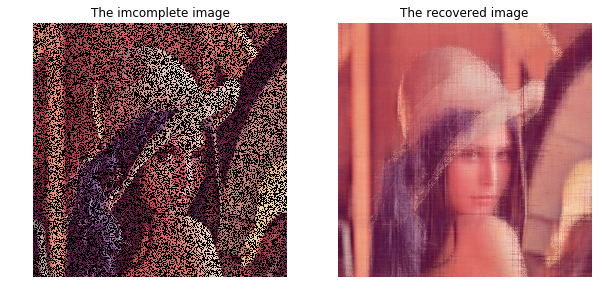

In [20]:
plt.subplots(1, 2, figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.imshow(sparse_image)
plt.title('The imcomplete image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_rec)
plt.title('The recovered image')
plt.axis('off')
plt.show()